In [27]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore  # For Z-score calculation

In [28]:
def load_data():
    return pd.read_csv("https://github.com/LinkLinucare/DataBusinessScience4/raw/main/kiva_loans.csv")

In [29]:
df = load_data()
print(df.groupby('country')['loan_amount'].sum().sort_values(ascending=False))

country
Philippines       55342225.0
Kenya             34534300.0
United States     31496375.0
Peru              30867400.0
Paraguay          29629075.0
                     ...    
Mauritania           15000.0
Afghanistan          14000.0
Virgin Islands       10000.0
Vanuatu               9250.0
Guam                  4300.0
Name: loan_amount, Length: 87, dtype: float64


## Data cleaning and manupulation

In [30]:
df_usa = df[df['country'] == 'United States']

In [31]:
df_usa.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
99,1080153,5000.0,5000.0,Food Production/Sales,Food,hire more staff to keep up with the volume of ...,US,United States,NaN,USD,NaN,2014-01-02 20:13:47+00:00,2014-03-10 22:53:12+00:00,2014-03-11 05:53:06+00:00,30.0,261,NaN,female,monthly,2014-01-02
116,653415,4000.0,4000.0,Cosmetics Sales,Retail,to purchase more inventory to sell,US,United States,San Diego,USD,249.0,2014-01-02 21:52:39+00:00,2013-12-05 08:00:00+00:00,2014-01-17 19:56:39+00:00,26.0,93,"#Refugee, #Woman Owned Biz, #Inspiring Story, ...",female,monthly,2014-01-02
231,1080154,10000.0,10000.0,Food Production/Sales,Food,outfit my new kitchen so that I can expand my ...,US,United States,NaN,USD,NaN,2014-01-02 21:46:47+00:00,2014-02-20 04:08:11+00:00,2014-02-20 12:08:03+00:00,36.0,280,NaN,female,monthly,2014-01-02
455,653761,5000.0,5000.0,Farming,Agriculture,to purchase a tractor,US,United States,"Pauma Valley, CA",USD,249.0,2014-01-03 20:52:30+00:00,2013-12-11 08:00:00+00:00,2014-01-13 19:33:49+00:00,32.0,158,"#Biz Durable Asset, #Vegan, #Inspiring Story, ...",male,monthly,2014-01-03
474,653803,5450.0,5450.0,Services,Services,to market her new business.,US,United States,"Baton Rouge, Louisiana",USD,173.0,2014-01-03 23:41:40+00:00,2013-12-04 08:00:00+00:00,2014-01-23 13:33:46+00:00,32.0,164,"#Woman Owned Biz, #Job Creator, user_favorite",female,monthly,2014-01-03


In [32]:
df_usa.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

In [33]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6093 entries, 99 to 670915
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  6093 non-null   int64  
 1   funded_amount       6093 non-null   float64
 2   loan_amount         6093 non-null   float64
 3   activity            6093 non-null   object 
 4   sector              6093 non-null   object 
 5   use                 5928 non-null   object 
 6   country_code        6093 non-null   object 
 7   country             6093 non-null   object 
 8   region              920 non-null    object 
 9   currency            6093 non-null   object 
 10  partner_id          1029 non-null   float64
 11  posted_time         6093 non-null   object 
 12  disbursed_time      4098 non-null   object 
 13  funded_time         3892 non-null   object 
 14  term_in_months      6093 non-null   float64
 15  lender_count        6093 non-null   int64  
 16  tags    

In [34]:
df_usa.isnull().sum()

,0
id,0
funded_amount,0
loan_amount,0
activity,0
sector,0
use,165
country_code,0
country,0
region,5173
currency,0


In [35]:
# **Outlier check med z-score
z_scores = zscore(df_usa['loan_amount'])
df_usa['outlier_loan_amount'] = (z_scores > 2) | (z_scores < -2)

<ipython-input-35-81ac6b7840e5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa['outlier_loan_amount'] = (z_scores > 2) | (z_scores < -2)


In [36]:
# Her checker vi hvor mange outliers der er.
outlier_count = df_usa['outlier_loan_amount'].sum()
print(f"Total number of outliers in loan amounts: {outlier_count}")

# Filtrer dem væk
df_usa = df_usa[df_usa['outlier_loan_amount'] == False]

Total number of outliers in loan amounts: 0


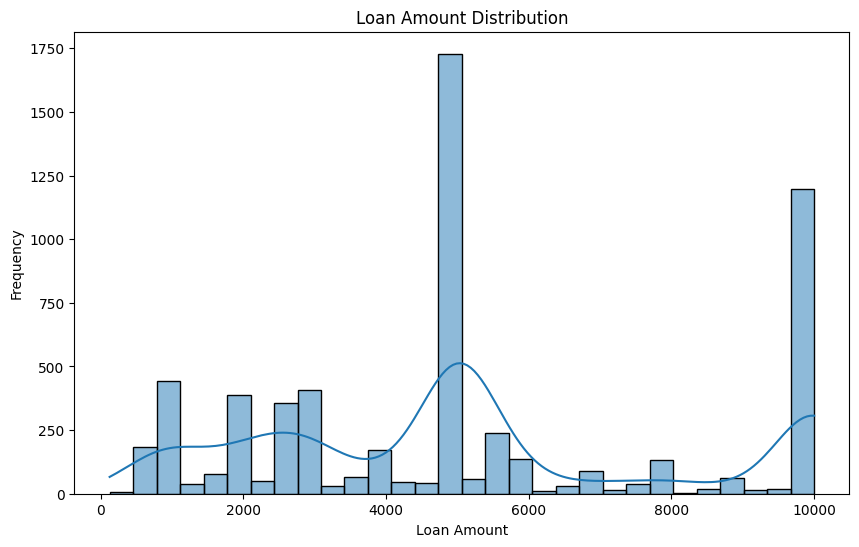

In [37]:
# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df_usa['loan_amount'], bins=30, kde=True)
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()

In [38]:
# Her går vi ind og finder lån under q1
minimum = df_usa['loan_amount'].min()
q1 = df_usa['loan_amount'].quantile(0.25)
af_filtered_usa = df_usa[(df_usa['loan_amount'] >= minimum) & (df_usa['loan_amount'] <= q1)]


In [39]:
# Tæller dem og sorterer dem
activity_counts_underq1 = af_filtered_usa['activity'].value_counts().sort_values(ascending=False)
top_activities_under_q1 = activity_counts_underq1.head(10)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


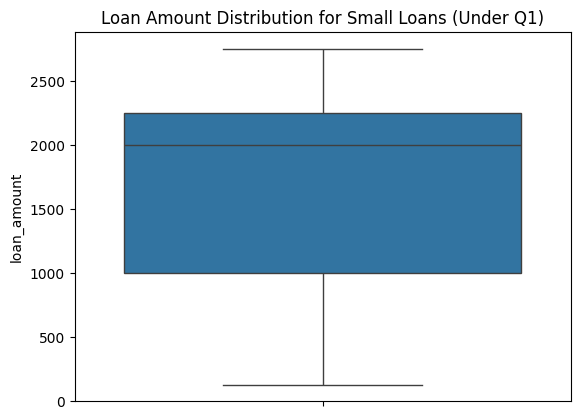

In [40]:
# Boksplot for små lånn
fig, ax = plt.subplots()
sns.boxplot(data=af_filtered_usa, y='loan_amount', ax=ax)
ax.set_title('Loan Amount Distribution for Small Loans (Under Q1)')
plt.show()

In [41]:
# Bruger den variable  med top activites
print("🏅 Top 10 Loan Activities for Small Loans (Under Q1):")
print(top_activities_under_q1)

🏅 Top 10 Loan Activities for Small Loans (Under Q1):
activity
Services                 371
Clothing                 113
General Store            108
Food Production/Sales    103
Cosmetics Sales           95
Restaurant                66
Crafts                    59
Entertainment             57
Cleaning Services         52
Technology                50
Name: count, dtype: int64


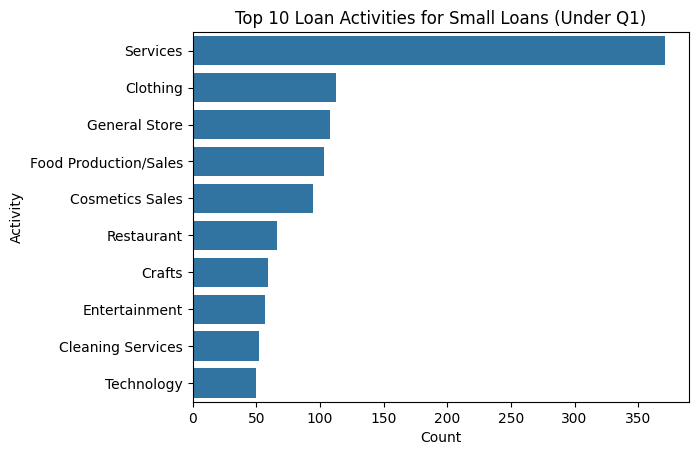

In [42]:
# barplæot der viser top 10 loan activites under q1
fig, ax = plt.subplots()
sns.barplot(x=top_activities_under_q1.values, y=top_activities_under_q1.index, ax=ax)
ax.set_xlabel("Count")
ax.set_ylabel("Activity")
ax.set_title("Top 10 Loan Activities for Small Loans (Under Q1)")
plt.show()

In [43]:
# For alle lån
activity_counts = df_usa['activity'].value_counts().sort_values(ascending=False).head(10)


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


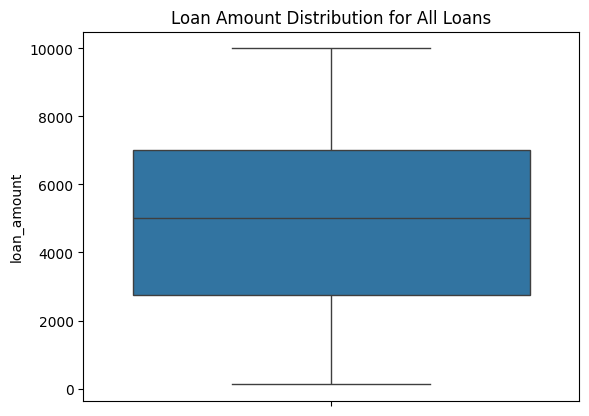

In [44]:
# Boksplot for alle lån
fig, ax = plt.subplots()
sns.boxplot(data=df_usa, y='loan_amount', ax=ax)
ax.set_title('Loan Amount Distribution for All Loans')
plt.show()

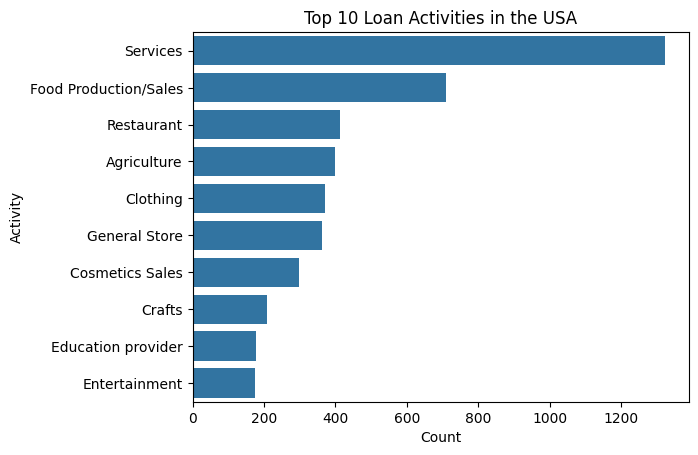

In [45]:
# Barpålot alle lån
fig, ax = plt.subplots()
sns.barplot(x=activity_counts.values, y=activity_counts.index, ax=ax)
ax.set_xlabel("Count")
ax.set_ylabel("Activity")
ax.set_title("Top 10 Loan Activities in the USA")
plt.show()

In [46]:
# NU sammenligner vi
comparison_df = pd.DataFrame({'all_loans': activity_counts, 'loans_under_q1': top_activities_under_q1})
comparison_df['percentage_small_loans'] = (comparison_df['loans_under_q1'] / comparison_df['all_loans']) * 100
comparison_df_sorted = comparison_df.sort_values(by='percentage_small_loans', ascending=False)


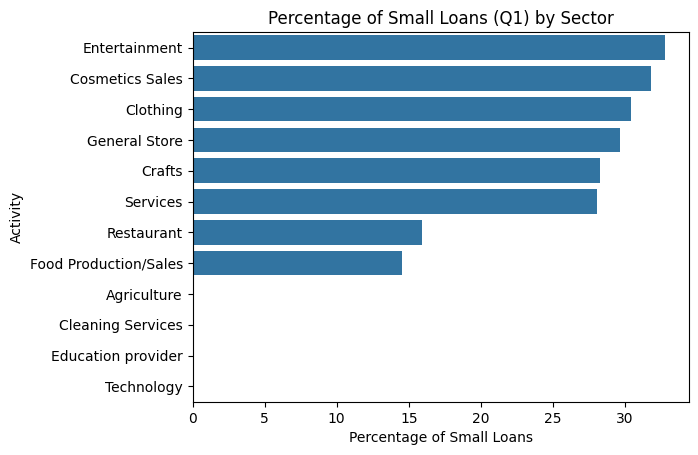

In [47]:
#Subplot der viser de mest repræsenterede lån i dem under q1
fig, ax = plt.subplots()
sns.barplot(x=comparison_df_sorted['percentage_small_loans'].values, y=comparison_df_sorted.index, ax=ax)
ax.set_xlabel("Percentage of Small Loans")
ax.set_ylabel("Activity")
ax.set_title("Percentage of Small Loans (Q1) by Sector")
plt.show()